In [ ]:
import torch
import numpy as np
import pcgym
import os
import glob
import time
from datetime import datetime
from PPO import PPO

import warnings
warnings.filterwarnings("ignore")

: 

In [2]:
nsteps = 100
T = 25
SP = {'Ca': [0.85 for _ in range(int(nsteps/2))] + [0.9 for _ in range(int(nsteps/2))]}


action_space = {'low': np.array([290]), 'high': np.array([302])}
observation_space = {'low': np.array([0.7,300,0.8]),'high': np.array([1,350,0.9])}
r_scale ={
    'Ca': 1e3 #Reward scale for each state
}

# Construct the environment parameter dictionary
env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, # Setpoint
    'o_space' : observation_space, # Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions 
    'model': 'cstr_ode', # Select the model
    'r_scale': r_scale, # Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, # Normalise the actions
    'normalise_o':True, # Normalise the states,
    'noise':True, # Add noise to the states
    'integration_method': 'casadi', # Select the integration method
    'noise_percentage':0.001 # Noise percentage
}

# Create environment
env = pcgym.make_env(env_params)

In [3]:
def train(env=env, env_name='cstr_ode'):
    print("============================================================================================")
    ####### initialize environment hyperparameters ######
    ## Note : print/log frequencies should be > than max_ep_len
    has_continuous_action_space = True
    max_ep_len = int(1e2)                       # max timesteps in one episode
    max_training_timesteps = max_ep_len * 10000          # break training loop if timeteps > max_training_timesteps

    print_freq = max_ep_len * 10                # print avg reward in the interval (in num timesteps)
    log_freq = max_ep_len * 5                   # log avg reward in the interval (in num timesteps)
    save_model_freq = int(1e5)                  # save model frequency (in num timesteps)

    action_std = 0.6                            # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05                # linearly decay action_std (action_std = action_std - action_std_decay_rate)
    min_action_std = 0.1                        # minimum action_std (stop decay after action_std <= min_action_std)
    action_std_decay_freq = int(1e5)          # action_std decay frequency (in num timesteps)

    ################ PPO hyperparameters ################
    update_timestep = max_ep_len * 5           # update policy every n timesteps
    K_epochs = 80                               # update policy for K epochs in one PPO update
    eps_clip = 0.2                              # clip parameter for PPO
    gamma = 0.99                                # discount factor
    lr_actor = 0.0003                           # learning rate for actor network
    lr_critic = 0.001                           # learning rate for critic network
    random_seed = 0                             # set random seed if required (0 = no random seed)
    state_dim = env.observation_space.shape[0]  # state space dimension
    action_dim = env.action_space.shape[0]      # action space dimension
    
    print("training environment name : " + env_name)
    
    ###################### logging ######################
    #### log files for multiple runs are NOT overwritten
    log_dir = "PPO_logs"
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)

    log_dir = log_dir + '/' + env_name + '/'
    if not os.path.exists(log_dir):
          os.makedirs(log_dir)

    #### get number of log files in log directory
    run_num = 0
    current_num_files = next(os.walk(log_dir))[2]
    run_num = len(current_num_files)

    #### create new log file for each run
    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

    print("current logging run number for " + env_name + " : ", run_num)
    print("logging at : " + log_f_name)
    #####################################################

    ################### checkpointing ###################

    directory = "PPO_preTrained"
    if not os.path.exists(directory):
          os.makedirs(directory)

    directory = directory + '/' + env_name + '/'
    if not os.path.exists(directory):
          os.makedirs(directory)


    checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num)
    print("save checkpoint path : " + checkpoint_path)
    #####################################################


    ############# print all hyperparameters #############
    print("--------------------------------------------------------------------------------------------")
    print("max training timesteps : ", max_training_timesteps)
    print("max timesteps per episode : ", max_ep_len)
    print("model saving frequency : " + str(save_model_freq) + " timesteps")
    print("log frequency : " + str(log_freq) + " timesteps")
    print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")
    print("--------------------------------------------------------------------------------------------")
    print("state space dimension : ", state_dim)
    print("action space dimension : ", action_dim)
    print("--------------------------------------------------------------------------------------------")
    if has_continuous_action_space:
        print("Initializing a continuous action space policy")
        print("--------------------------------------------------------------------------------------------")
        print("starting std of action distribution : ", action_std)
        print("decay rate of std of action distribution : ", action_std_decay_rate)
        print("minimum std of action distribution : ", min_action_std)
        print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")
    else:
        print("Initializing a discrete action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("PPO update frequency : " + str(update_timestep) + " timesteps")
    print("PPO K epochs : ", K_epochs)
    print("PPO epsilon clip : ", eps_clip)
    print("discount factor (gamma) : ", gamma)
    print("--------------------------------------------------------------------------------------------")
    print("optimizer learning rate actor : ", lr_actor)
    print("optimizer learning rate critic : ", lr_critic)
    if random_seed:
        print("--------------------------------------------------------------------------------------------")
        print("setting random seed to ", random_seed)
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)
    #####################################################

    print("============================================================================================")

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")

    # logging file
    log_f = open(log_f_name,"w+")
    log_f.write('episode,timestep,reward\n')

    # printing and logging variables
    print_running_reward = 0
    print_running_episodes = 0

    log_running_reward = 0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0

    # training loop
    while time_step <= max_training_timesteps:

        # obs, state = env.reset()
        state, obs = env.reset()
        
        current_ep_reward = 0

        for t in range(1, max_ep_len+1):

            # select action with policy
            action = ppo_agent.select_action(state)
            state, reward, done, _, _ = env.step(action)

            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)

            time_step += 1
            current_ep_reward += reward

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # log in logging file
            if time_step % log_freq == 0:

                # log average reward till last episode
                log_avg_reward = log_running_reward / log_running_episodes
                log_avg_reward = round(log_avg_reward, 4)

                log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
                log_f.flush()

                log_running_reward = 0
                log_running_episodes = 0

            # printing average reward
            if time_step % print_freq == 0:

                # print average reward till last episode
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

                print_running_reward = 0
                print_running_episodes = 0

            # save model weights
            if time_step % save_model_freq == 0:
                print("--------------------------------------------------------------------------------------------")
                print("saving model at : " + checkpoint_path)
                ppo_agent.save(checkpoint_path)
                print("model saved")
                print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
                print("--------------------------------------------------------------------------------------------")

            # break; if the episode is over
            if done:
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1

        log_running_reward += current_ep_reward
        log_running_episodes += 1

        i_episode += 1

    log_f.close()
    env.close()

    # print total training time
    print("============================================================================================")
    end_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)
    print("Finished training at (GMT) : ", end_time)
    print("Total training time  : ", end_time - start_time)
    print("============================================================================================")

    

In [4]:
train()

training environment name : cstr_ode
current logging run number for cstr_ode :  7
logging at : PPO_logs/cstr_ode//PPO_cstr_ode_log_7.csv
save checkpoint path : PPO_preTrained/cstr_ode/PPO_cstr_ode_0_7.pth
--------------------------------------------------------------------------------------------
max training timesteps :  1000000
max timesteps per episode :  100
model saving frequency : 100000 timesteps
log frequency : 500 timesteps
printing average reward over episodes in last : 1000 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  3
action space dimension :  1
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  0.6
decay rate of std of action distribution :  0.05
minimum std of action distri

### Inference

In [5]:
# Initialize a new PPO instance with the same parameters as when training
state_dim = 3  
action_dim = 1 
lr_actor = 0.0003
lr_critic = 0.001
gamma = 0.99
K_epochs = 80
eps_clip = 0.2
has_continuous_action_space = True
action_std_init = 0.6

# Create a new PPO instance
new_ppo_instance = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init)




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



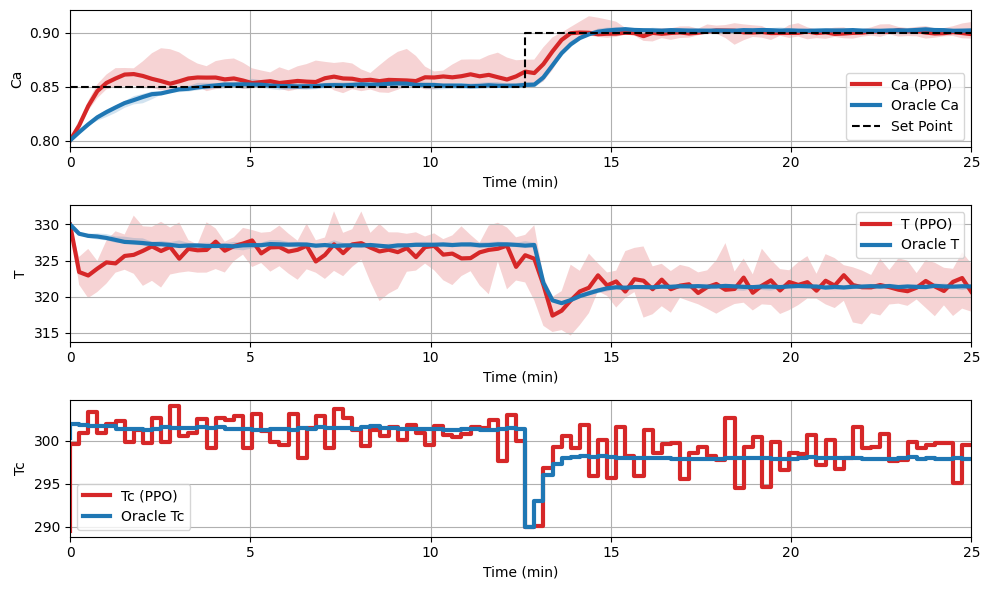

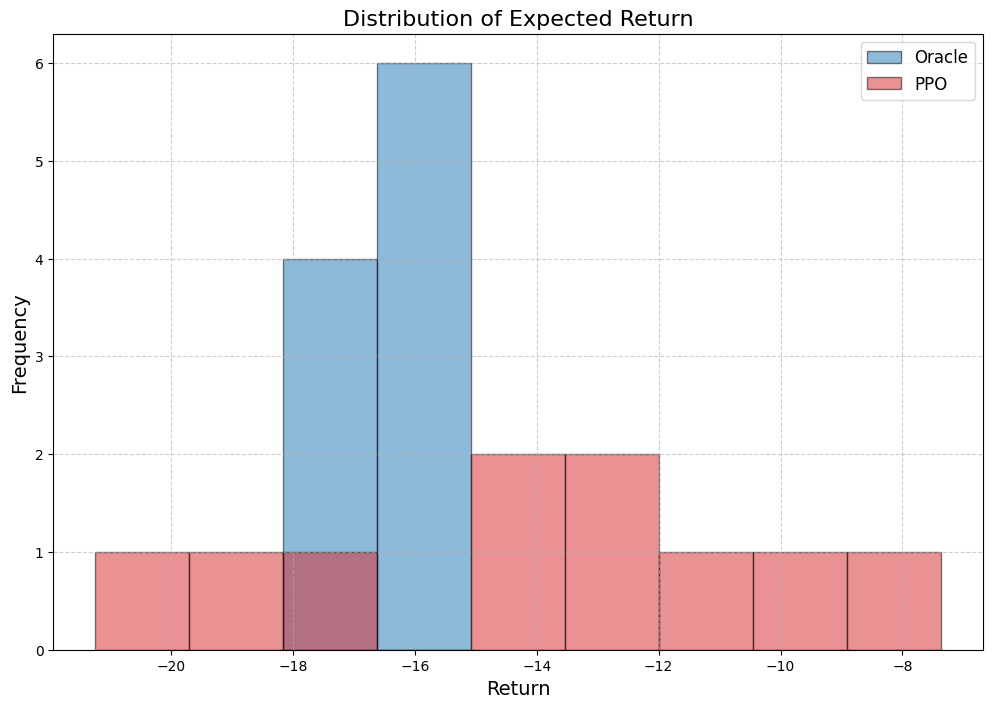

In [6]:
# Load the saved state_dict from the .pth file
checkpoint_path = "PPO_preTrained/cstr_ode/PPO_cstr_ode_0_5.pth"
new_ppo_instance.load(checkpoint_path)
evaluator, data = env.plot_rollout({'PPO':new_ppo_instance},reps=10,oracle = True, dist_reward=True, MPC_params={'N':15,'R':5})

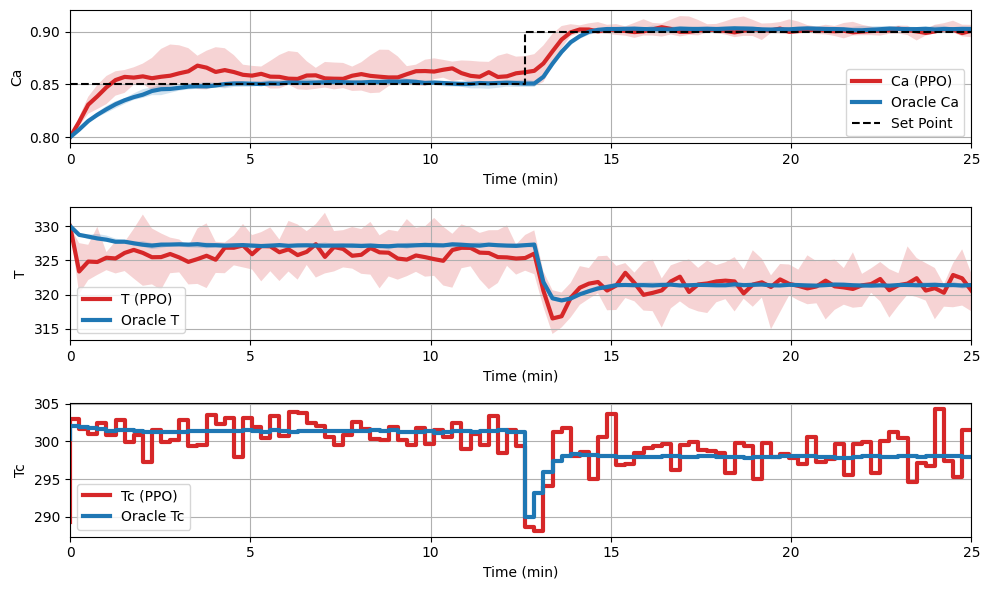

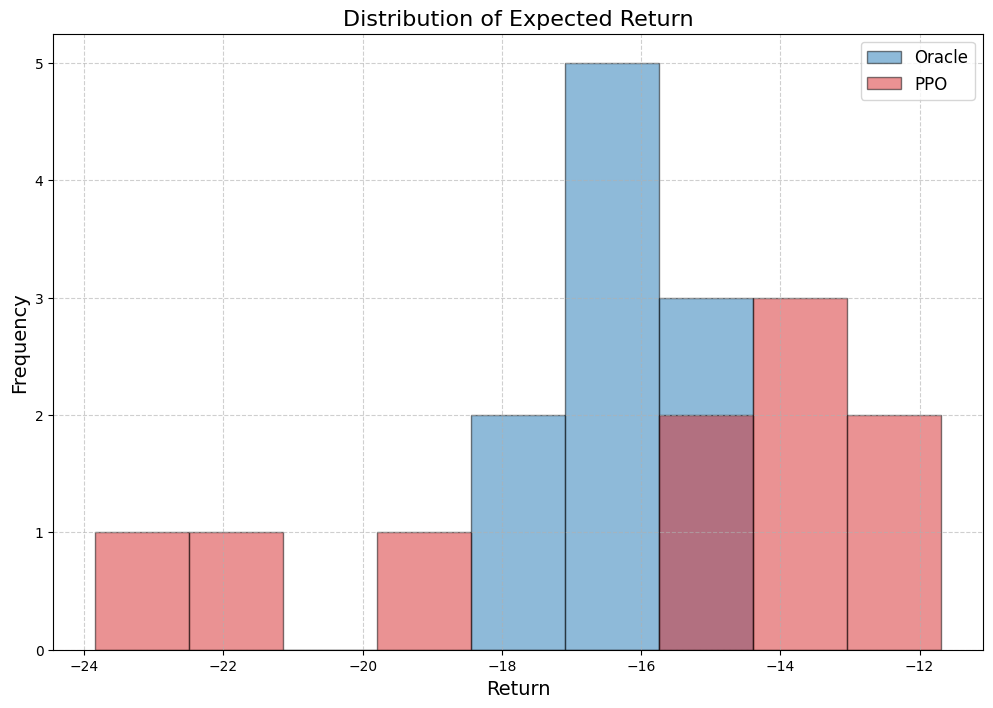

In [8]:
# Load the saved state_dict from the .pth file
checkpoint_path = "PPO_preTrained/cstr_ode/PPO_cstr_ode_0_6.pth"
new_ppo_instance.load(checkpoint_path)
evaluator, data = env.plot_rollout({'PPO':new_ppo_instance},reps=10,oracle = True, dist_reward=True, MPC_params={'N':15,'R':5})


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



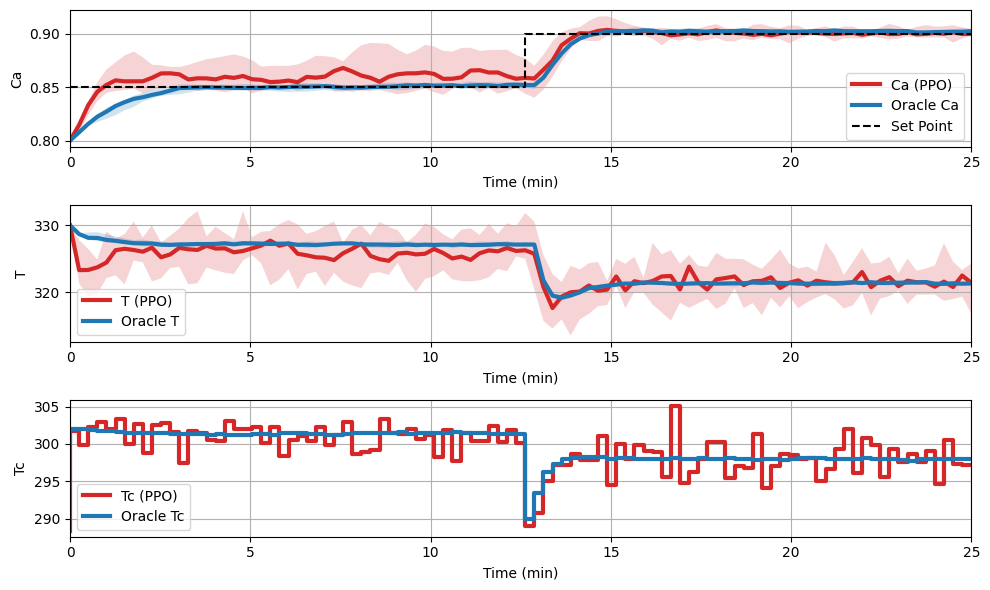

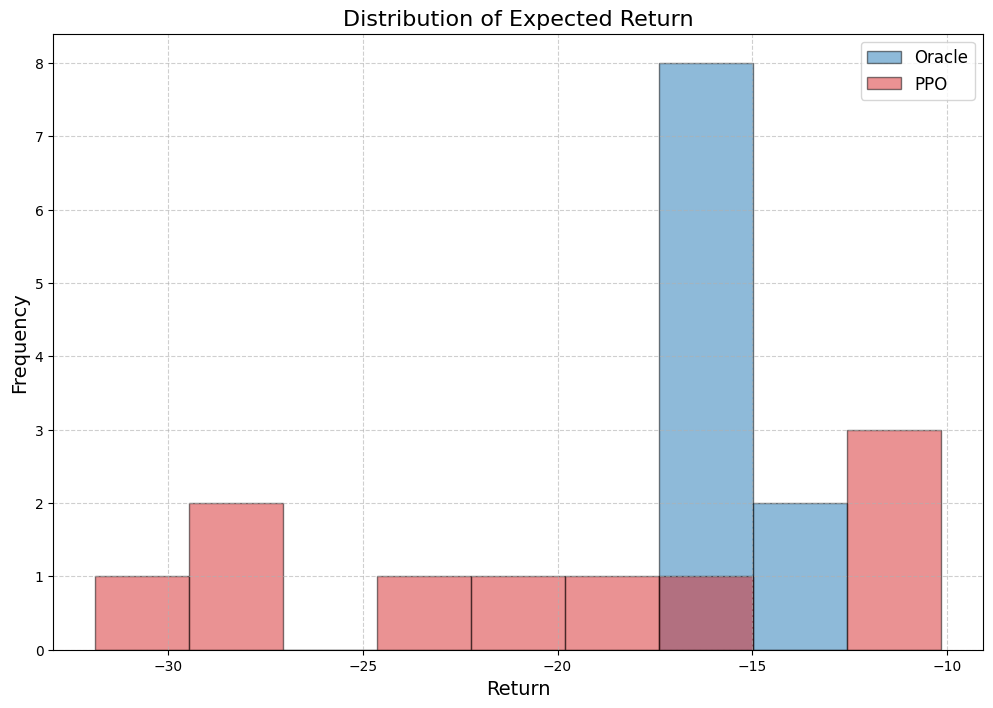

In [6]:
# Load the saved state_dict from the .pth file
checkpoint_path = "PPO_preTrained/cstr_ode/PPO_cstr_ode_0_7.pth"
new_ppo_instance.load(checkpoint_path)
evaluator, data = env.plot_rollout({'PPO':new_ppo_instance},reps=10,oracle = True, dist_reward=True, MPC_params={'N':15,'R':5})